In [1]:
#Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
import random
from PIL import Image
import tensorflow as tf
from glob import glob
from tensorflow.keras.layers import Input,Dense,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization,InputLayer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Extracting Data

We need to unzip dog-vs-cats folder then extract and unzip train.zip then distribute the images in to the following directory

Download link for the dataset
https://www.kaggle.com/c/dogs-vs-cats/data

In [2]:
# dogs_vs_cats
# ├── test
# │   ├── cats
# │   └── dogs
# ├── train
# │   ├── cats
# │   └── dogs
# └── validation
#     ├── cats
#     └── dogs

# Creating the above directory
base_dir = 'dogs-vs-cats'
split_dir = ['train','test']

In [3]:
for split_dir in split_dir:
    label_dir=['dogs','cats']
    
    for label_dir in label_dir:
        new_dir = os.path.join(base_dir,split_dir,label_dir)
        os.makedirs(new_dir,exist_ok=True)

In [4]:
#extracting train.zip from dogs-vs-cat
shutil.unpack_archive('dogs-vs-cats.zip')
os.remove('test1.zip')
os.remove('sampleSubmission.csv')

#unzipping train
shutil.unpack_archive('train.zip')
os.remove('train.zip')

In [5]:
#Redistribution from train to dogs-vs-cats directory
train_dir = 'train'
PERCENT_OF_DATA = 1 #The precentage of the total data to be used in decimal

for file in os.listdir(train_dir):
    if not file.endswith('jpg'):
        continue
    src = os.path.join(train_dir,file)
    if np.random.uniform() > PERCENT_OF_DATA:
        os.remove(src)
        continue
    type_dir = np.random.choice(['train','test'],p=[0.75,0.25])
    if file.startswith('cat'):
        final_dir = os.path.join(base_dir,type_dir,'cats',file)
    elif file.startswith('dog'):
        final_dir = os.path.join(base_dir,type_dir,'dogs',file)
    
    #We have the final location of the image now we move it there
    try:
        shutil.move(src,final_dir)
    except Exception as e:
        print(e)

#Run the below line if the enviornment is run as administrator 
#os.remove(train_dir)

In [6]:
#Counting the number of entries in each directory
total = 0
for dire in ['train','test']:
    for label in ['dogs','cats']:
        print(dire,label,len(os.listdir(base_dir+'/'+dire+'/'+label)))
        total +=len(os.listdir(base_dir+'/'+dire+'/'+label))


print(f'Total number of images: {total}')

train dogs 9434
train cats 9285
test dogs 3066
test cats 3215
Total number of images: 25000


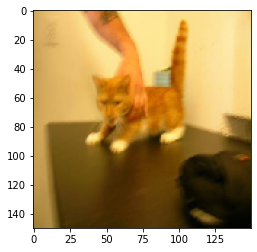

In [7]:
#displaying an image
img_path = base_dir+'/train/cats/'+os.listdir(base_dir+'/train/cats')[0]
img = image.load_img(img_path, target_size=(150,150))
plt.imshow(img)

# Image Generators

In [16]:
datagen = ImageDataGenerator(rescale=1/255.,
                            horizontal_flip=True,
                            width_shift_range=0.1,
                            height_shift_range=0.1)

test_datagen = ImageDataGenerator(rescale=1/255.)

In [17]:
batch_size = 16 #The initial value was 16 for the batch size but realizing that was to small I increased it.
target_size = (128,128)

traingen = datagen.flow_from_directory(base_dir+'/train',
                              target_size= target_size,
                              batch_size= batch_size,
                              class_mode= 'binary',
                              shuffle=False)

"""valgen = datagen.flow_from_directory(base_dir+'/validation',
                              target_size= target_size,
                              batch_size= batch_size,
                              class_mode= 'binary',
                              shuffle=False)"""

testgen = test_datagen.flow_from_directory(base_dir+'/test',
                              target_size= target_size,
                              batch_size= batch_size,
                              class_mode= 'binary',
                              shuffle=False)

Found 18751 images belonging to 2 classes.
Found 6249 images belonging to 2 classes.


# CNN Model

The ways to regularize the model\
I tried adam and rmsprop both were underfitting quiet significantly. SGD seems to work the best

In [18]:
model = Sequential()

input_shape = (128,128,3)
L2 = tf.keras.regularizers.l2(0.001)

model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
for i in [64,128]:
    model.add(Conv2D(i,kernel_size=(3,3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)            

In [19]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(0.001,momentum=0.9), metrics=['accuracy'])

In [20]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [learning_rate_reduction]

In [21]:
history = model.fit_generator(traingen,
                    epochs=35,
                    validation_data = testgen)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1172 steps, validate for 391 steps
Epoch 1/35
1172/1172 [==============================] - 107s 92ms/step - loss: 0.6931 - accuracy: 0.5199 - val_loss: 0.6859 - val_accuracy: 0.5444
Epoch 2/35
1172/1172 [==============================] - 100s 86ms/step - loss: 0.6896 - accuracy: 0.5525 - val_loss: 0.6879 - val_accuracy: 0.5428
Epoch 3/35
1172/1172 [==============================] - 102s 87ms/step - loss: 0.6899 - accuracy: 0.5360 - val_loss: 0.6768 - val_accuracy: 0.6318
Epoch 4/35
1172/1172 [==============================] - 105s 90ms/step - loss: 0.6812 - accuracy: 0.5740 - val_loss: 0.6658 - val_accuracy: 0.6196
Epoch 5/35
1172/1172 [==============================] - 113s 97ms/step - loss: 0.6579 - accuracy: 0.6172 - val_loss: 0.6242 - val_accuracy: 0.6510
Epoch 6/35
1172/1172 [==============================] - 115s 98ms/step - loss: 0.6290 - accura

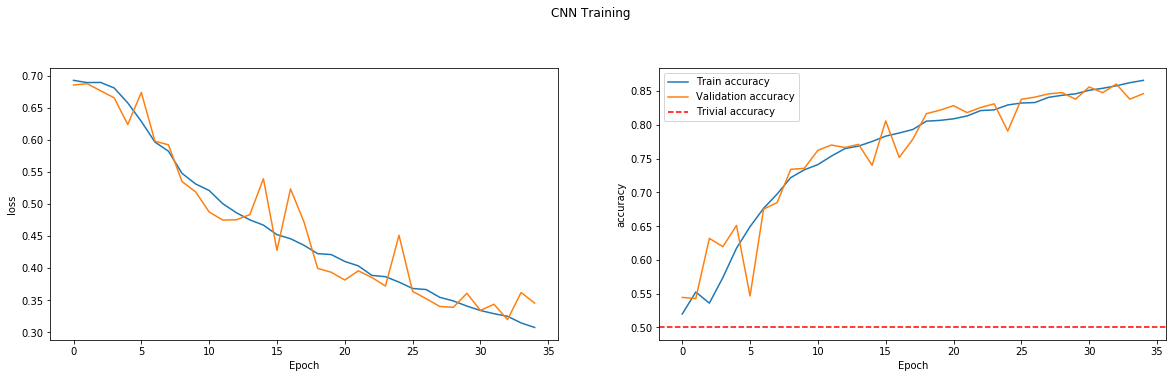

In [22]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
for i, metric in enumerate(['loss', 'accuracy']): 
    ax[i].plot(history.history[metric], label=('Train '+metric))
    ax[i].plot(history.history['val_'+metric], label='Validation '+metric)
    if metric == 'accuracy': ax[i].axhline(0.5, c='r', ls='--', label='Trivial accuracy')
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel(metric)
plt.suptitle('CNN Training', y=1.05)
plt.legend()

In [23]:
## Evaluation
metric = model.evaluate(testgen)
print(f'The Loss of evluation is: {metric[0]}')
print(f'The Accuracy of evluation is: {metric[1]:.2%}')

  ...
    to  
  ['...']
391/391 [==============================] - 13s 33ms/step - loss: 0.3453 - accuracy: 0.8461
The Loss of evluation is: 0.34533237132346234
The Accuracy of evluation is: 84.61%


In [ ]:
#Comment out if not neccessary
model.save('modelt1')

# Transfer Learning Using VGG

In [7]:
#defining the data generators
d_input_shape = (240,240)
batch_size = 16
traingen = datagen.flow_from_directory(base_dir+'/train',
                                      target_size = d_input_shape,
                                      class_mode='categorical',
                                      batch_size=batch_size,
                                      shuffle=False)

testgen = test_datagen.flow_from_directory(base_dir+'/test',
                                      target_size = d_input_shape,
                                      class_mode='categorical',
                                      batch_size=batch_size,
                                      shuffle=False)

Found 18751 images belonging to 2 classes.
Found 6249 images belonging to 2 classes.


In [8]:
model = Sequential()
L2 = tf.keras.regularizers.l2(0.001)
input_shape = (240,240,3)

model = tf.keras.applications.VGG19(include_top=False, input_shape=input_shape)
for layer in model.layers:
    layer.trainable=False
flat = Flatten()(model.layers[-1].output)
hidden1 = Dense(128,activation='relu')(flat)
output = Dense(2,activation='softmax')(hidden1)

model = Model(inputs=model.inputs, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 240, 240, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 240, 240, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 120, 120, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 120, 120, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 120, 120, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 60, 60, 128)       0     

In [9]:
model.compile(loss = 'categorical_crossentropy', optimizer= optimizers.Adam(0.001), metrics=['accuracy'])

In [10]:
history = model.fit(traingen,
                   epochs=10,
                   validation_data = testgen)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1172 steps, validate for 391 steps
Epoch 1/10
1172/1172 [==============================] - 579s 494ms/step - loss: 0.5716 - accuracy: 0.7941 - val_loss: 0.3827 - val_accuracy: 0.8925
Epoch 2/10
1172/1172 [==============================] - 299s 255ms/step - loss: 0.3555 - accuracy: 0.8809 - val_loss: 0.4416 - val_accuracy: 0.8382
Epoch 3/10
1172/1172 [==============================] - 300s 256ms/step - loss: 0.2964 - accuracy: 0.8930 - val_loss: 0.2322 - val_accuracy: 0.9211
Epoch 4/10
1172/1172 [==============================] - 300s 256ms/step - loss: 0.2552 - accuracy: 0.9034 - val_loss: 0.2105 - val_accuracy: 0.9264
Epoch 5/10
1172/1172 [==============================] - 305s 260ms/step - loss: 0.2389 - accuracy: 0.9079 - val_loss: 0.2212 - val_accuracy: 0.9176
Epoch 6/10
1172/1172 [==============================] - 296s 253ms/step - loss: 0.2244 - accuracy: 0.9132 - val_loss: 0.1898 - val_accuracy: 0.9291
Epoch 7/10
1172/1

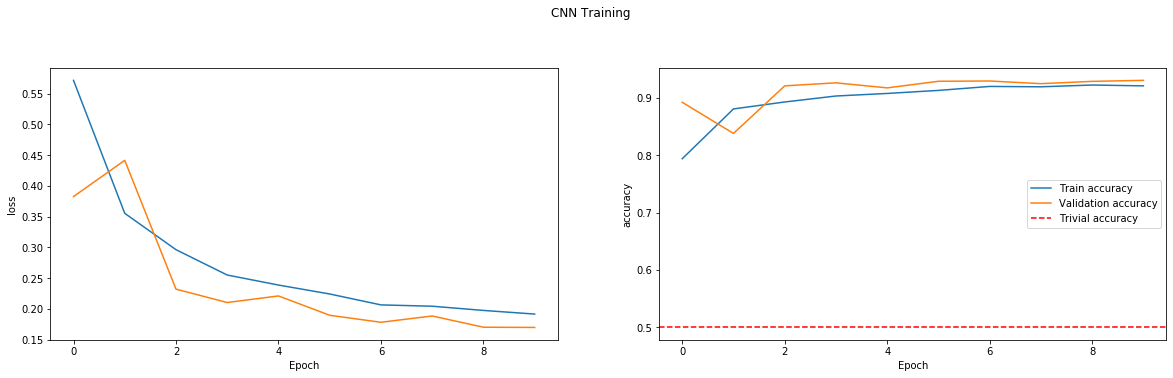

In [11]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
for i, metric in enumerate(['loss', 'accuracy']): 
    ax[i].plot(history.history[metric], label=('Train '+metric))
    ax[i].plot(history.history['val_'+metric], label='Validation '+metric)
    if metric == 'accuracy': ax[i].axhline(0.5, c='r', ls='--', label='Trivial accuracy')
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel(metric)
plt.suptitle('CNN Training', y=1.05)
plt.legend()

In [12]:
metric = model.evaluate(testgen)
print(f'The Loss of evluation is: {metric[0]}')
print(f'The Accuracy of evluation is: {metric[1]:.2%}')

  ...
    to  
  ['...']
391/391 [==============================] - 41s 106ms/step - loss: 0.1700 - accuracy: 0.9307
The Loss of evluation is: 0.16997590799437232
The Accuracy of evluation is: 93.07%


In [15]:
model.save('model1')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model1\assets


# Predicting using the Models

In [61]:
def load_img(path,size):
    img = Image.open(path)
    img = img.resize((size,size),Image.ANTIALIAS)
    img = np.asarray(img)/255
    plt.imshow(img)
    img = img.reshape(1,size,size,3)
    plt.show()
    return img

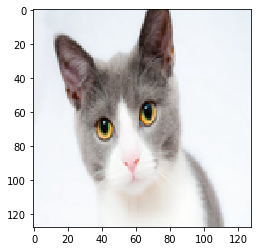

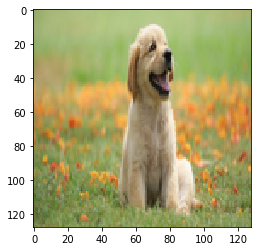

In [64]:
img1 = load_img('cat.jpeg',128)
img2 = load_img('Dog.jpg',128)

In [75]:
## Predictions using the trained model
model_t = load_model('modelt1')
predictions1 = model_t.predict(img1)
predictions2 = model_t.predict(img2)

print(f'Prediction for Image 1 (Cat): {predictions1[0][0]:.0f}')
print(f'Prediction for Image 2 (Dog): {predictions2[0][0]:.0f}')

Prediction for Image 1 (Cat): 0
Prediction for Image 2 (Dog): 1


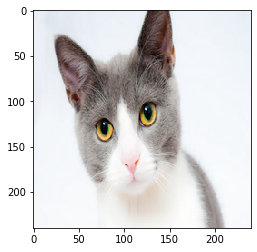

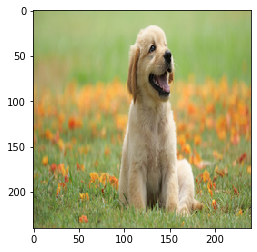

In [78]:
## Predictions using the VGG transfered learning model
img1 = load_img('cat.jpeg',240)
img2 = load_img('Dog.jpg',240)
model_vgg = load_model('model1')
predictions1 = model_vgg.predict(img1)
predictions2 = model_vgg.predict(img2)

In [86]:
print(f'Prediction for Image 1(Cat): {predictions1[0][0]:.3%} Cat, {predictions1[0][1]:.3%} Dog')
print(f'Prediction for Image 2(Dog): {predictions2[0][0]:.3%} Cat, {predictions2[0][1]:.3%} Dog')

Prediction for Image 1(Cat): 99.999% Cat, 0.001% Dog
Prediction for Image 2(Dog): 3.396% Cat, 96.604% Dog


In [91]:
print(tf.__version__)

2.1.0
